# Initial Setup

## Ignoring potential warnings

In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## Plotly template setup

In [2]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

template_tg = go.layout.Template()
template_tg.layout.colorway = ['#253540', '#E71C24', '#F3C707', '#D4D3D4', '#747A7A']
template_tg.layout.title = {'font': {'size': 22}}
template_tg.layout.colorscale = {'sequential': [[0.0, '#253540'], [1.0, '#F3C707']]}
template_tg.layout.coloraxis = {'colorbar': {'outlinewidth': 5,'outlinecolor': 'rgb(255,255,255)'}}
template_tg.layout.font = {'family': 'Microsoft PhagsPa','color': 'rgb(0,0,0)', 'size': 15}

axis_style = {'gridcolor': 'rgb(0,0,0)','linecolor': 'rgb(0,0,0)','tickcolor': 'rgb(0,0,0)'}
template_tg.layout.xaxis = axis_style
template_tg.layout.yaxis = axis_style

template_tg.layout.height = 400
template_tg.layout.width = 600
template_tg.layout.bargroupgap = 0.15
template_tg.layout.margin=dict(l=0, r=0, b=0, t=0)

# Combining user-defined template with base template
pio.templates["template_tg"] = template_tg
pio.templates.default = "simple_white+template_tg"

## Reading Past and Present Set

In [3]:
import datetime as dt
import pandas as pd
import numpy as np
import os

# Mount filename
base_path = "../../assets/data/nips"

# Reading file
past_df = pd.read_csv(os.path.abspath(os.path.join(base_path, "past.csv")))
pres_df = pd.read_csv(os.path.abspath(os.path.join(base_path, "present.csv")))

# Display df
display("Past set:", past_df.head())
display("Present set:", pres_df.head())

'Past set:'

year  id                                               text
0  1987   1  self organization associative database applica...
1  1987   2  capacity kanerva associative memory exponentia...
2  1987   3  supervise learning probability distribution ne...
3  1987   4  constrained differential optimization constrai...
4  1987   5  towards organize principle layered perceptual ...

'Present set:'

year    id                                               text
0  2003  2345  error bound transductive learning compression ...
1  2003  2346  predict speech intelligibility population neur...
2  2003  2347  markov model automated interval analysis marko...
3  2003  2348  perception structure physical world unknown mu...
4  2003  2349  find probable configuration loopy belief propa...

# Feature Selection

## Auxiliar function

In [17]:
MAX_DF = 0.6; MIN_DF = 5

def user_custom_vocabulary(data):
    # Get unique words for each document
    unique = data.apply(lambda x: list(set(x.split())))

    # Calculate the words document frequency
    words_document_frequency = unique.explode().value_counts() / len(unique)

    top = MAX_DF if MAX_DF < 1 else MAX_DF /  len(unique)
    bottom = MIN_DF if MIN_DF < 1 else MIN_DF /  len(unique)

    # Find words
    mask_top = words_document_frequency > top
    mask_bottom = bottom > words_document_frequency
    mask_wdf = mask_top | mask_bottom
    freq_stop_words = list(words_document_frequency[mask_wdf].index)
    vocabulary = list(words_document_frequency[~mask_wdf].index)
    
    # Statistics
    length = len(str(len(words_document_frequency))) + 1
    print(f"{len(words_document_frequency)}".rjust(length), "- raw vocabulary length")
    print(f"{len(vocabulary)}".rjust(length), "- new vocabulary length\n")
    print(f"{mask_wdf.sum()}".rjust(length), "- new stop words founded")
    print(f"{mask_top.sum()}".rjust(length), f"- above  {top:.8f}")
    print(f"{mask_bottom.sum()}".rjust(length), f"- bellow {bottom:.8f}\n")
    
    fig = px.histogram(words_document_frequency)

    xs1 = [bottom]*2
    xs2 = [top]*2
    ys = [0, 10_000]

    fig.add_traces([
        go.Scatter(x=xs1, y=ys, line={'color':'#E71C24'}, mode='lines'),
        go.Scatter(x=xs2, y=ys, line={'color':'#E71C24'}, mode='lines')
    ])

    fig.update_layout(
        xaxis_title='Ocurrence',
        yaxis_title='Log(Count)',
        showlegend=False
    )

    fig.update_layout(
        xaxis_title='Ocurrence', # xaxis label
        yaxis_title='Log(Count)', # yaxis label
        showlegend=False,
    )

    fig.update_yaxes(type="log")

    fig.show()
    
    return vocabulary

## Past Vocabulary

### Cutting stop-words

In [18]:
past_vocabulary = user_custom_vocabulary(past_df.text)

 77512 - raw vocabulary length
 11928 - new vocabulary length

 65584 - new stop words founded
   104 - above  0.60000000
 65480 - bellow 0.00216638



### Corpus and dictionary

In [7]:
from gensim.corpora import Dictionary

# Create Dictionary
past_id2word = Dictionary([past_vocabulary])

# Create Corpus with Term Document Frequency
past_df["corpus"] = past_df.text.str.split().apply(past_id2word.doc2bow, allow_update=False)

# Keeping corpus and tokens
past_corpus = past_df["corpus"].to_list()
past_tokens = past_df["corpus"].apply(lambda x: [token for token_id, count in x for token in [past_id2word[token_id]]*count]).to_list()

## Present Vocabulary

### Cutting stop-words

In [8]:
pres_vocabulary = user_custom_vocabulary(pres_df.text)

 90122 - raw vocabulary length
 19583 - new vocabulary length

 70539 - new stop words founded
   183 - above  0.60000000
 70356 - bellow 0.00135685



### Corpus and dictionary

In [9]:
from gensim.corpora import Dictionary

# Create Dictionary
pres_id2word = Dictionary([pres_vocabulary])

# Create Corpus with Term Document Frequency
pres_df["corpus"] = pres_df.text.str.split().apply(pres_id2word.doc2bow, allow_update=False)

# Keeping corpus and tokens
pres_corpus = pres_df["corpus"].to_list()
pres_tokens = pres_df["corpus"].apply(lambda x: [token for token_id, count in x for token in [pres_id2word[token_id]]*count]).to_list()

## Vocabulary intersection

In [10]:
intersec_vocabulary = set(pres_vocabulary) & set(past_vocabulary)
print("Common words:", len(intersec_vocabulary))

Common words: 9745


In [11]:
past_vocab_ids = [past_id2word.token2id[tk] for tk in intersec_vocabulary]
pres_vocab_ids = [pres_id2word.token2id[tk] for tk in intersec_vocabulary]

# Latent Dirichlet Allocation (LDA)

## Parameters and function definition

In [13]:
no_topics = 25
alpha = 0.1
beta = 1.0

### Train and Compute Model Perplexity and Coherence Score

In [32]:
from gensim.models import LdaMulticore, CoherenceModel

def train_evaluate_lda(corpus, tokens, id2word, tabs='  '):
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=no_topics, 
        alpha=alpha,
        eta=beta,
        random_state=100,
        chunksize=100,
        passes=10,
        per_word_topics=True,
    )
    
    # Compute Perplexity - a measure of how good the model is. lower the better.
    print(tabs + 'Perplexity:', lda_model.log_perplexity(corpus))
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=id2word, coherence='c_v')

    with np.errstate(invalid='ignore'):
        coherence_lda_c_v = coherence_model_lda.get_coherence()

    print(tabs + 'Coherence Score using c_v:', coherence_lda_c_v)

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=id2word, coherence='u_mass')

    with np.errstate(invalid='ignore'):
        coherence_lda_u_mass = coherence_model_lda.get_coherence()

    print(tabs + 'Coherence Score using u_mass:', coherence_lda_u_mass) 
    
    return lda_model

### Applying document Labels

In [255]:
THRESHOLD = 1 / (no_topics)

def get_document_labels(lda_model, corpus, id_list, prefix="topic", threshold=THRESHOLD):
    
    lda_df = lda_model.get_document_topics(corpus, minimum_probability=0)
    lda_df = pd.DataFrame(list(lda_df))

    topic_cols = ['{}_{:02d}'.format(prefix, i) for i in range(no_topics)]
    lda_df.columns = topic_cols

    for i in range(len(lda_df.columns)):
        lda_df.iloc[:,i] = lda_df.iloc[:,i].apply(lambda x: x[1])

    # Aplly 1 if has the topic
    if THRESHOLD:
        lda_df = lda_df.fillna(0).applymap(lambda x: int(x > THRESHOLD))
    else:
        lda_df = lda_df.applymap(lambda x: max(x, 1)).fillna(0).astype(int)

    lda_df.insert(0, "id", id_list)
    
    return lda_df

def get_document_probs(lda_model, corpus, id_list, prefix="topic"):
    
    lda_df = lda_model.get_document_topics(corpus, minimum_probability=0)
    lda_df = pd.DataFrame(list(lda_df))

    topic_cols = ['{}_{:02d}'.format(prefix, i) for i in range(no_topics)]
    lda_df.columns = topic_cols

    for i in range(len(lda_df.columns)):
        lda_df.iloc[:,i] = lda_df.iloc[:,i].apply(lambda x: x[1])

    lda_df.insert(0, "id", id_list)
    
    return lda_df

## Past set

In [34]:
past_lda_model = train_evaluate_lda(past_corpus, past_tokens, past_id2word)

  Perplexity: -7.550805882133907
  Coherence Score using c_v: 0.5450226296244164
  Coherence Score using u_mass: -1.8016523567932228


In [35]:
past_lda_model.print_topics(num_topics=5, num_words=5)

[(21,
  '0.015*"dynamic" + 0.013*"equation" + 0.011*"state" + 0.008*"field" + 0.008*"attractor"'),
 (9,
  '0.047*"classifier" + 0.029*"classification" + 0.018*"class" + 0.018*"training" + 0.018*"feature"'),
 (8,
  '0.041*"image" + 0.013*"component" + 0.009*"matrix" + 0.009*"pixel" + 0.008*"local"'),
 (4,
  '0.033*"signal" + 0.029*"filter" + 0.027*"motion" + 0.016*"noise" + 0.016*"frequency"'),
 (1,
  '0.069*"memory" + 0.014*"capacity" + 0.013*"associative" + 0.012*"store" + 0.011*"representation"')]

### Latex table

In [139]:
for i in range(5):
#     print(" & ".join(["\\multicolumn{{1}}{{c|}}{{Topic {:02d}}}".format(5*i+j) for j in range(5)]), "\\\\ \\hline")
    print(" & ".join(["\\textbf{{Topic {:02d}}}".format(5*i+j) for j in range(5)]), "\\\\ \\hline")
    for k in range(10):
        lista = []
        for list_tup in [[(past_lda_model.get_topic_terms(5*i+z)[k+j]) for j in range(1)] for z in range(5)]:
#         for list_tup in [[(5*i+z, k+j) for j in range(1)] for z in range(5)]:
            lista += list_tup
            
        palavras = []
        for tup in lista:
            palavras += [past_id2word[tup[0]]]#, '{:.3f}'.format(tup[1])]
            
#         print(lista)
        print(" & ".join(palavras), '\\\\ ')
    print("\\hline & & & & \\\\ \\hline")

\hline \multicolumn{1}{c}{Topic 00} & \multicolumn{1}{c}{Topic 01} & \multicolumn{1}{c}{Topic 02} & \multicolumn{1}{c}{Topic 03} & \multicolumn{1}{c}{Topic 04} \\ \hline
\multicolumn{1}{c}{ object } & \multicolumn{1}{c}{ memory } & \multicolumn{1}{c}{ hippocampus } & \multicolumn{1}{c}{ circuit } & \multicolumn{1}{c}{ signal } \\ 
\multicolumn{1}{c}{ image } & \multicolumn{1}{c}{ capacity } & \multicolumn{1}{c}{ hippocampal } & \multicolumn{1}{c}{ chip } & \multicolumn{1}{c}{ filter } \\ 
\multicolumn{1}{c}{ feature } & \multicolumn{1}{c}{ associative } & \multicolumn{1}{c}{ conditioning } & \multicolumn{1}{c}{ analog } & \multicolumn{1}{c}{ motion } \\ 
\multicolumn{1}{c}{ recognition } & \multicolumn{1}{c}{ store } & \multicolumn{1}{c}{ episode } & \multicolumn{1}{c}{ current } & \multicolumn{1}{c}{ noise } \\ 
\multicolumn{1}{c}{ view } & \multicolumn{1}{c}{ representation } & \multicolumn{1}{c}{ animal } & \multicolumn{1}{c}{ voltage } & \multicolumn{1}{c}{ frequency } \\ 
\multico

### Wordclouds

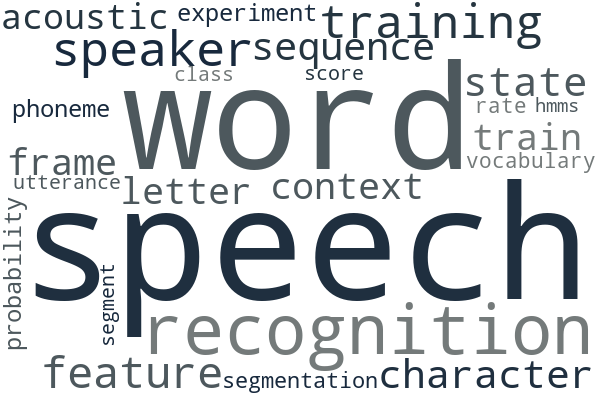

In [222]:
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

words = 25

for topico in range(past_lda_model.num_topics):

    cmap = matplotlib.colors.ListedColormap(['#18293D', '#1F2F3F', '#253540', '#4D585D', '#747A7A'], name='from_list', N=None)

    img = WordCloud(width=600, height=400, background_color='white',
                    min_font_size=10, collocations=False, colormap=cmap
    ).fit_words(dict(past_lda_model.show_topic(topico, words)))

    img.to_file(filename='past_wordclouds/past_{:02d}_{}.png'.format(topico, words))

img.to_image()

### Labeling

In [256]:
past_doc_topics_df = get_document_labels(past_lda_model, past_corpus, past_df['id'], 'past')
past_doc_topics_df.head()

id  past_00  past_01  past_02  past_03  past_04  past_05  past_06  past_07  \
0   1        1        0        0        0        1        0        0        0   
1   2        0        1        0        0        0        1        0        0   
2   3        0        0        0        0        0        1        0        0   
3   4        0        0        0        0        0        0        0        0   
4   5        0        0        0        0        0        1        0        0   

   past_08  ...  past_15  past_16  past_17  past_18  past_19  past_20  \
0        1  ...        0        1        0        1        0        0   
1        0  ...        0        0        0        1        0        0   
2        0  ...        0        0        0        0        0        0   
3        0  ...        0        0        0        0        0        1   
4        1  ...        0        1        0        0        0        0   

   past_21  past_22  past_23  past_24  
0        0        1        0        1  
1        0        0        0        0  
2        0        1        0        0  
3        1        0        0        0  
4        1        0        0        0  

[5 rows x 26 columns]

In [258]:
past_doc_probs = get_document_probs(past_lda_model, past_corpus, past_df['id'], 'past')
past_doc_probs.head()

id   past_00   past_01   past_02   past_03   past_04   past_05   past_06  \
0   1  0.100890  0.039691  0.000081  0.016118  0.042079  0.008379  0.000082   
1   2  0.000114  0.580741  0.000114  0.000114  0.000114  0.082298  0.000114   
2   3  0.000159  0.000159  0.000159  0.000159  0.000159  0.216614  0.000159   
3   4  0.000070  0.000070  0.000070  0.036587  0.005072  0.000070  0.000070   
4   5  0.000057  0.000057  0.000057  0.000057  0.001910  0.159817  0.000057   

    past_07   past_08  ...   past_15   past_16   past_17   past_18   past_19  \
0  0.000082  0.049033  ...  0.000082  0.216855  0.000082  0.060958  0.000082   
1  0.000114  0.000114  ...  0.000114  0.000114  0.000114  0.334464  0.000114   
2  0.000159  0.000159  ...  0.000159  0.000159  0.000159  0.000159  0.000159   
3  0.000070  0.000070  ...  0.000070  0.000070  0.000070  0.000070  0.000070   
4  0.013945  0.209165  ...  0.000057  0.047286  0.000057  0.000057  0.000057   

    past_20   past_21   past_22   past_23   past_24  
0  0.000082  0.009901  0.062511  0.000081  0.121335  
1  0.000114  0.000114  0.000114  0.000114  0.000114  
2  0.006679  0.000159  0.665529  0.000159  0.000159  
3  0.855725  0.086533  0.005641  0.000070  0.000070  
4  0.022274  0.107697  0.011260  0.000057  0.000057  

[5 rows x 26 columns]

## Present set

In [38]:
pres_lda_model = train_evaluate_lda(pres_corpus, pres_tokens, pres_id2word)

  Perplexity: -7.614409445217301
  Coherence Score using c_v: 0.6156099719179752
  Coherence Score using u_mass: -1.7326272846258923


In [39]:
pres_lda_model.print_topics(num_topics=5, num_words=5)

[(13,
  '0.089*"cluster" + 0.020*"clustering" + 0.018*"manifold" + 0.010*"embedding" + 0.010*"local"'),
 (6,
  '0.033*"neuron" + 0.024*"spike" + 0.017*"network" + 0.010*"cell" + 0.010*"stimulus"'),
 (0,
  '0.032*"word" + 0.029*"topic" + 0.018*"document" + 0.011*"language" + 0.008*"inference"'),
 (20,
  '0.023*"brain" + 0.021*"region" + 0.017*"subject" + 0.015*"patient" + 0.014*"functional"'),
 (3,
  '0.017*"sampling" + 0.015*"chain" + 0.014*"markov" + 0.012*"inference" + 0.012*"gibb"')]

### Latex table

In [137]:
for i in range(5):
#     print(" & ".join(["\\multicolumn{{1}}{{c|}}{{Topic {:02d}}}".format(5*i+j) for j in range(5)]), "\\\\ \\hline")
    print(" & ".join(["\\textbf{{Topic {:02d}}}".format(5*i+j) for j in range(5)]), "\\\\ \\hline")
    for k in range(10):
        lista = []
        for list_tup in [[(pres_lda_model.get_topic_terms(5*i+z)[k+j]) for j in range(1)] for z in range(5)]:
#         for list_tup in [[(5*i+z, k+j) for j in range(1)] for z in range(5)]:
            lista += list_tup
            
        palavras = []
        for tup in lista:
            palavras += [pres_id2word[tup[0]]]#, '{:.3f}'.format(tup[1])]
            
#         print(lista)
        print(" & ".join(palavras), '\\\\ ')
    print("\\hline & & & & \\\\ \\hline")

\textbf{Topic 00} & \textbf{Topic 01} & \textbf{Topic 02} & \textbf{Topic 03} & \textbf{Topic 04} \\ \hline
word & wasserstein & signal & sampling & rank \\ 
topic & orbit & source & chain & item \\ 
document & transport & event & markov & user \\ 
language & lattice & frequency & inference & query \\ 
inference & conical & speech & gibb & ranking \\ 
latent & sinkhorn & sensor & posterior & permutation \\ 
sentence & simplicial & speaker & sampler & preference \\ 
representation & cone & noise & mcmc & score \\ 
text & cuturi & audio & particle & worker \\ 
dirichlet & barycenter & channel & carlo & rating \\ 
\hline & & & & \\ \hline
\textbf{Topic 05} & \textbf{Topic 06} & \textbf{Topic 07} & \textbf{Topic 08} & \textbf{Topic 09} \\ \hline
policy & neuron & network & image & gradient \\ 
action & spike & layer & object & update \\ 
reward & network & deep & pixel & iteration \\ 
agent & cell & training & detection & convergence \\ 
game & stimulus & train & segmentation & stochastic 

### Wordclouds

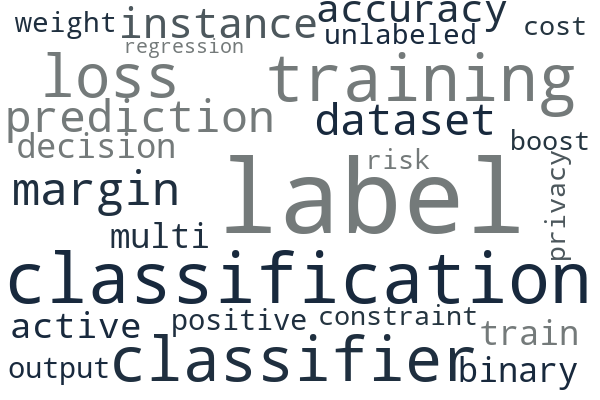

In [221]:
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

words = 25

for topico in range(pres_lda_model.num_topics):

    cmap = matplotlib.colors.ListedColormap(['#18293D', '#1F2F3F', '#253540', '#4D585D', '#747A7A'], name='from_list', N=None)

    img = WordCloud(width=600, height=400, background_color='white',
                    min_font_size=10, collocations=False, colormap=cmap
    ).fit_words(dict(pres_lda_model.show_topic(topico, words)))

    img.to_file(filename='pres_wordclouds/pres_{:02d}_{}.png'.format(topico, words))

img.to_image()

### Labeling

In [223]:
pres_doc_topics_df = get_document_labels(pres_lda_model, pres_corpus, pres_df['id'], 'pres')
pres_doc_topics_df.head()

id  pres_00  pres_01  pres_02  pres_03  pres_04  pres_05  pres_06  \
0  2345        0        0        0        0        0        0        0   
1  2346        0        0        1        0        0        0        1   
2  2347        0        0        1        1        0        0        0   
3  2348        0        0        1        0        0        0        1   
4  2349        0        0        0        1        0        0        0   

   pres_07  pres_08  ...  pres_15  pres_16  pres_17  pres_18  pres_19  \
0        0        0  ...        0        1        0        0        0   
1        0        0  ...        0        0        0        0        0   
2        0        1  ...        0        0        0        0        0   
3        0        1  ...        0        0        0        1        0   
4        0        0  ...        0        0        1        0        0   

   pres_20  pres_21  pres_22  pres_23  pres_24  
0        0        0        0        0        1  
1        0        0        0        0        1  
2        1        0        0        0        1  
3        0        0        0        0        0  
4        0        0        0        0        0  

[5 rows x 26 columns]

In [259]:
pres_doc_probs = get_document_probs(pres_lda_model, pres_corpus, pres_df['id'], 'pres')
pres_doc_probs.head()

id   pres_00   pres_01   pres_02   pres_03   pres_04   pres_05   pres_06  \
0  2345  0.000090  0.000089  0.000089  0.007836  0.000090  0.000090  0.000090   
1  2346  0.032461  0.000094  0.642082  0.000094  0.000094  0.000094  0.163061   
2  2347  0.000091  0.000091  0.538738  0.202358  0.000091  0.000091  0.006970   
3  2348  0.002123  0.000103  0.076243  0.000103  0.000103  0.011707  0.229955   
4  2349  0.000110  0.000110  0.000110  0.111501  0.000110  0.000110  0.000110   

    pres_07   pres_08  ...   pres_15   pres_16   pres_17   pres_18   pres_19  \
0  0.000090  0.000090  ...  0.000089  0.090331  0.009581  0.000089  0.000089   
1  0.000094  0.000094  ...  0.000094  0.000094  0.011831  0.000094  0.000094   
2  0.000091  0.041230  ...  0.000091  0.018679  0.000091  0.000091  0.000091   
3  0.000103  0.091038  ...  0.000103  0.000103  0.000103  0.090749  0.000103   
4  0.000110  0.015153  ...  0.000110  0.000110  0.411006  0.000110  0.011279   

    pres_20   pres_21   pres_22   pres_23   pres_24  
0  0.000089  0.000090  0.000089  0.000090  0.373794  
1  0.000094  0.014093  0.000094  0.000094  0.042942  
2  0.041207  0.000091  0.000091  0.018194  0.131084  
3  0.000103  0.000103  0.000103  0.027074  0.000103  
4  0.000110  0.000110  0.000110  0.000110  0.000110  

[5 rows x 26 columns]

## Associating past and present topics

### Top N matching

In [268]:
pct = 0.25
topn = 50

map_past_pres = []
for i in range(no_topics):
    for y in range(no_topics):
        past_i_set = {past_id2word.id2token[topic_id] for topic_id, prob in past_lda_model.get_topic_terms(i, topn=topn)}
        pres_y_set = {pres_id2word.id2token[topic_id] for topic_id, prob in pres_lda_model.get_topic_terms(y, topn=topn)}
        
        # Set intesect
        corresp_set = past_i_set & pres_y_set
        set_length = len(corresp_set)
        
        map_past_pres.append({"past": i, "pres": y, "count": set_length})    

In [269]:
topic_corresp = pd.DataFrame(map_past_pres)#.nlargest(columns='count', n=no_topics*2)
topic_corresp.T

0    1    2    3    4    5    6    7    8    9    ...  615  616  617  \
past     0    0    0    0    0    0    0    0    0    0  ...   24   24   24   
pres     0    1    2    3    4    5    6    7    8    9  ...   15   16   17   
count    5    0    5    0    3    1    2    6   23    1  ...    0    1    2   

       618  619  620  621  622  623  624  
past    24   24   24   24   24   24   24  
pres    18   19   20   21   22   23   24  
count    4    3    0    4    0    2    6  

[3 rows x 625 columns]

### Global Matching

In [262]:
past_topics_df = pd.DataFrame(past_lda_model.get_topics()[:, past_vocab_ids], columns=intersec_vocabulary)
pres_topics_df = pd.DataFrame(pres_lda_model.get_topics()[:, pres_vocab_ids], columns=intersec_vocabulary)

In [263]:
score_past_pre = []
for i, row_i in past_topics_df.iterrows():
    for y, row_y in pres_topics_df.iterrows():
        
        score = np.sqrt(np.sum(((row_i / row_i.sum()) - (row_y / row_y.sum()))**2))
#         score = (row_i*row_y).sum() / np.sqrt((row_i**2).sum() * (row_y*row_y).sum()) 
        
        score_past_pre.append({"past": i, "pres": y, "score": score})
score_past_pre = pd.DataFrame(score_past_pre)#.nsmallest(columns='score', n=no_topics*2)
score_past_pre.T.round(3)

0      1      2      3      4      5      6      7      8      9    \
past   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
pres   0.000  1.000  2.000  3.000  4.000  5.000  6.000  7.000  8.000  9.000   
score  0.096  0.085  0.101  0.095  0.107  0.104  0.096  0.099  0.055  0.094   

       ...     615     616     617     618     619     620     621     622  \
past   ...  24.000  24.000  24.000  24.000  24.000  24.000  24.000  24.000   
pres   ...  15.000  16.000  17.000  18.000  19.000  20.000  21.000  22.000   
score  ...   0.127   0.097   0.112   0.096   0.092   0.101   0.111   0.078   

        623     624  
past   24.0  24.000  
pres   23.0  24.000  
score   0.1   0.097  

[3 rows x 625 columns]

### Combine associations

In [74]:
def bold_common_words(words, intersec):
    w_list = []
    for w in words:
        if w in intersec:
            w_list.append('\033[1m' + w + '\033[0m')
#         else:
#             w_list.append(w)
    return w_list

In [270]:
combine_df = pd.merge(topic_corresp, score_past_pre, on=['past', 'pres'], how='inner')#[['past', 'pres']]
combine_df.T

0         1         2         3         4         5        6    \
past   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
pres   0.000000  1.000000  2.000000  3.000000  4.000000  5.000000  6.00000   
count  5.000000  0.000000  5.000000  0.000000  3.000000  1.000000  2.00000   
score  0.096452  0.085495  0.101099  0.095286  0.107389  0.103759  0.09564   

            7          8         9    ...        615        616        617  \
past   0.000000   0.000000  0.000000  ...  24.000000  24.000000  24.000000   
pres   7.000000   8.000000  9.000000  ...  15.000000  16.000000  17.000000   
count  6.000000  23.000000  1.000000  ...   0.000000   1.000000   2.000000   
score  0.098505   0.055031  0.094305  ...   0.127274   0.097144   0.111584   

             618        619        620        621       622       623  \
past   24.000000  24.000000  24.000000  24.000000  24.00000  24.00000   
pres   18.000000  19.000000  20.000000  21.000000  22.00000  23.00000   
count   4.000000   3.000000   0.000000   4.000000   0.00000   2.00000   
score   0.095678   0.091891   0.101373   0.111027   0.07804   0.10007   

             624  
past   24.000000  
pres   24.000000  
count   6.000000  
score   0.097415  

[4 rows x 625 columns]

In [51]:
topic_combination = combine_df.copy()
topic_combination['agg'] = topic_combination['count'] / topic_combination['score']
topic_combination = topic_combination.nlargest(columns='agg', n=10).reset_index(drop=True)

topic_combination['past'] = topic_combination['past'].apply(lambda x: '{:02d}'.format(x))
topic_combination['pres'] = topic_combination['pres'].apply(lambda x: '{:02d}'.format(x))
topic_combination['count'] = topic_combination['count'].apply(lambda x: '{:.2%}'.format(x/50))
topic_combination['score'] = topic_combination['score'].apply(lambda x: '{:6.3f}'.format(x))
topic_combination['agg'] = topic_combination['agg'].apply(lambda x: '{:6.2f}'.format(x))

print(topic_combination.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
past & pres &   count &   score &      agg \\
\midrule
  11 &   06 &  58.00\% &   0.026 &  1119.71 \\
  10 &   05 &  56.00\% &   0.031 &   911.39 \\
  14 &   16 &  44.00\% &   0.040 &   555.48 \\
  20 &   09 &  38.00\% &   0.036 &   528.22 \\
  18 &   11 &  40.00\% &   0.043 &   467.59 \\
  07 &   12 &  34.00\% &   0.038 &   445.64 \\
  04 &   02 &  54.00\% &   0.061 &   440.94 \\
  00 &   08 &  46.00\% &   0.055 &   417.94 \\
  05 &   03 &  32.00\% &   0.047 &   341.65 \\
  22 &   07 &  36.00\% &   0.057 &   313.72 \\
\bottomrule
\end{tabular}



In [78]:
intersection_table = []
for idx, row in topic_combination.iterrows():
    
    past_terms = [past_id2word.id2token[topic_id] for topic_id, _ in past_lda_model.get_topic_terms(int(row['past']), topn=20)]
    pres_terms = [pres_id2word.id2token[topic_id] for topic_id, _ in pres_lda_model.get_topic_terms(int(row['pres']), topn=20)]
    
    intersec = set(past_terms) & set(pres_terms)
    
#     print('Past {}'.format(row['past'][-2:]), '&', ", ".join(bold_common_words(past_terms, intersec)), '\\\\')
#     print('Pres {}'.format(row['pres'][-2:]), '&', ", ".join(bold_common_words(pres_terms, intersec)), '\\\\ \\hline')
    
#     print("past-{:02d} => {}".format(int(row['past']), ", ".join(bold_common_words(past_terms, intersec))))
#     print("pres-{:02d} => {}\n".format(int(row['pres']), ", ".join(bold_common_words(pres_terms, intersec))))    
    print("{:02d} & {:02d} &".format(int(row['past']), int(row['pres'])), " & ".join(bold_common_words(past_terms, intersec)[:5]), "\\\\")
    

11 & 06 & neuron & spike & cell & response & stimulus \\
10 & 05 & policy & action & control & reward & reinforcement \\
14 & 16 & gaussian & mixture & likelihood & prior & bayesian \\
20 & 09 & gradient & constraint & convergence & update & cost \\
18 & 11 & bound & theorem & loss & bind & proof \\
07 & 12 & subject & stimulus & human & response & trial \\
04 & 02 & signal & filter & noise & frequency & channel \\
00 & 08 & object & image & recognition & pixel & shape \\
05 & 03 & markov & inference & sequence & likelihood & bayesian \\
22 & 07 & unit & training & layer & train & hide \\


## Saving useful information

In [274]:
# import pickle
# import json

# # Saving vocabularies
# with open('data/past_vocabulary.json', 'w') as f:
#     json.dump(past_vocabulary, f)
# with open('data/pres_vocabulary.json', 'w') as f:
#     json.dump(pres_vocabulary, f)
    
# # Saving lda_models
# with open('data/past_lda_model.pkl', 'wb') as f:
#     pickle.dump(past_lda_model, f)
# with open('data/pres_lda_model.pkl', 'wb') as f:
#     pickle.dump(pres_lda_model, f)
    
# # Saving dictionaries
# with open('data/past_id2word.pkl', 'wb') as f:
#     pickle.dump(past_id2word, f)
# with open('data/pres_id2word.pkl', 'wb') as f:
#     pickle.dump(pres_id2word, f)
    
# # Saving label dataframes
# past_doc_topics_df.to_csv('data/past_labels.csv', index=False)
# pres_doc_topics_df.to_csv('data/pres_labels.csv', index=False)

# # Saving documents probs
# past_doc_probs.to_csv('data/past_probs.csv', index=False)
# pres_doc_probs.to_csv('data/pres_probs.csv', index=False)

# # Saving topic combination
# combine_df.to_csv('data/combination.csv', index=False)

In [5]:
# import pandas as pd
# import pickle
# import json

# # Saving vocabularies
# with open('data/past_vocabulary.json', 'r') as f:
#     past_vocabulary = json.load(f)
# with open('data/pres_vocabulary.json', 'r') as f:
#     pres_vocabulary = json.load(f)
    
# # Saving lda_models
# with open('data/past_lda_model.pkl', 'rb') as f:
#     past_lda_model = pickle.load(f)
# with open('data/pres_lda_model.pkl', 'rb') as f:
#     pres_lda_model = pickle.load(f)
    
# # Saving dictionaries
# with open('data/past_id2word.pkl', 'rb') as f:
#     past_id2word = pickle.load(f)
# with open('data/pres_id2word.pkl', 'rb') as f:
#     pres_id2word = pickle.load(f)
    
# # Saving label dataframes
# past_doc_topics_df = pd.read_csv('data/past_labels.csv')
# pres_doc_topics_df = pd.read_csv('data/pres_labels.csv')

# # Saving documents probs
# past_doc_probs = pd.read_csv('data/past_probs.csv')
# pres_doc_probs = pd.read_csv('data/pres_probs.csv')

# # Saving topic combination
# combine_df = pd.read_csv('data/combination.csv')

# Analizing topics distribution

## Auxiliar function

In [11]:
import plotly.graph_objects as go
import plotly.express as px


def update_figure(fig, title, xlabel, ylabel):
    fig.update_layout(
        title_text=title,
        xaxis_title=xlabel, # xaxis label
        yaxis_title=ylabel, # yaxis label
        showlegend=False,
        width=600, height=400,
        bargroupgap=0.2,
        margin=dict(l=0, r=0, b=0)
    )
    return fig


def topic_dist_stats(topics_df, prefix):
    
    topic_cols = [col for col in topics_df.columns if prefix in col]
    
    ## TOPIC IN CORPUS
    print("Topic in corpus:")
        
    # Count topic occurrence
    count_topics = topics_df[topic_cols].sum()
    total_topics = pd.DataFrame({"count": count_topics, "percent": count_topics/len(topics_df)})

    # Sorting
    total_topics.sort_values(by=["count"], ascending=False, inplace=True)

    # Display head and tail
    display(pd.concat([
        total_topics.head(), 
        pd.DataFrame([{'count': '...', 'percent': '...'}]), 
        total_topics.tail()
    ]).T)
    
    # Display histogram
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=total_topics["percent"],
        xbins={
            "start":0.0, 
            "end": 0.5,
            "size":0.025
        }
    ))
    fig = update_figure(fig, "", "Percent over documents", "Count")
    fig.show()
    
    # Display Bar distribuition
    total_topics.sort_index(inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=total_topics.index,
        y=total_topics["percent"],
    ))
    fig = update_figure(fig, "", "Topics", "Percent")
    fig.show()
    
    ## TOPICS PER DOCUMENT
    print("Topics per docuement:")
    
    # Display 
    per_doc_topics = pd.DataFrame({"id": topics_df['id'], "topics": topics_df[topic_cols].sum(axis=1)})
    display(per_doc_topics.head(20).T)
    
    # Display topic distribution histogram
    fig = px.histogram(per_doc_topics["topics"])
    fig = update_figure(fig, "", "Topics per Document", "Count")
    fig.show()

## Past Dataset

In [12]:
topic_dist_stats(past_doc_topics_df, "past")

Topic in corpus:


past_22  past_05   past_14   past_16   past_11    0   past_19  \
count       1038      751       716       672       532  ...        47   
percent  0.44974  0.32539  0.310225  0.291161  0.230503  ...  0.020364   

           past_23    past_13     past_02     past_15  
count           38         28          23          11  
percent  0.0164645  0.0121317  0.00996534  0.00476603

Topics per docuement:


0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
id       1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17   
topics   9   3   3   2   6   5   6   3   4   3   3   6   5   4   2   4   4   

        17  18  19  
id      18  19  20  
topics   1   5   7

## Present dataset

In [18]:
topic_dist_stats(pres_doc_topics_df, "pres")

Topic in corpus:


pres_14   pres_16  pres_24   pres_09   pres_11    0    pres_20  \
count        1313      1297     1204      1096       988  ...        150   
percent  0.356309  0.351967  0.32673  0.297422  0.268114  ...  0.0407056   

           pres_18    pres_15     pres_01 pres_22  
count          105         61           9       0  
percent  0.0284939  0.0165536  0.00244233       0

Topics per docuement:


0     1     2     3     4     5     6     7     8     9     10  \
id      2345  2346  2347  2348  2349  2350  2351  2352  2353  2354  2355   
topics     4     4     5     7     3     3     7     5     4     3     4   

          11    12    13    14    15    16    17    18    19  
id      2356  2357  2358  2359  2360  2361  2362  2363  2364  
topics     2     6     3     4     4     6     3     7     5